<a href="https://colab.research.google.com/github/harini9804/fake-image-detection/blob/master/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
%cp ./weibo_data_split.zip /content

In [0]:
!unzip weibo_data_split.zip -d /content/

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import os

Using TensorFlow backend.


In [0]:
import numpy as np

In [0]:
# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = '/content/drive/My Drive/Colab Notebooks/bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

In [0]:
base_dir = '/content/weibo_data_split'
train_data_dir = base_dir +'/train'
validation_data_dir = base_dir +'/validation'

nb_train_samples = 2*len(os.listdir(train_data_dir+'/fake'))
nb_validation_samples = 2*len(os.listdir(validation_data_dir+'/fake'))
epochs = 50
batch_size = 64

In [5]:
# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')











Model loaded.


In [6]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [0]:
new_model = Sequential()
new_model.add(model)
new_model.add(top_model)


In [0]:
new_model.load_weights('/content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt')

In [0]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:25]:
    layer.trainable = False

In [11]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum = 0.9),
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 6794 images belonging to 2 classes.
Found 970 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [0]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
from keras.callbacks import ModelCheckpoint
#callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,verbose=1)
callbacks_list = [cp_callback]

In [0]:
new_model.load_weights(checkpoint_path)

In [0]:
# fine-tune the model
history = new_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks = callbacks_list)


Epoch 1/50
106/106 [==============================] - 85s 806ms/step - loss: 5.1920 - acc: 0.6507 - val_loss: 5.2589 - val_acc: 0.6396

Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt
Epoch 2/50
106/106 [==============================] - 84s 791ms/step - loss: 5.2606 - acc: 0.6468 - val_loss: 5.3193 - val_acc: 0.6369

Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt
Epoch 3/50
106/106 [==============================] - 84s 789ms/step - loss: 5.2651 - acc: 0.6452 - val_loss: 5.2732 - val_acc: 0.6380

Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt
Epoch 4/50
106/106 [==============================] - 83s 786ms/step - loss: 5.3096 - acc: 0.6407 - val_loss: 5.0605 - val_acc: 0.6512

Epoch 00004: saving model to /content/drive/My Drive/Colab Notebooks/cp_traLearn.ckpt
Epoch 5/50
106/106 [==============================] - 83s 784ms/step - loss: 5.3607 - acc: 0.6379 - val_loss: 5

In [0]:
new_model_json = new_model.to_json()
with open("new_model_50and50ep.json", "w") as json_file:
  json_file.write(new_model_json)
new_model.save_weights('new_model_50and50ep.h5')

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve

In [0]:
import matplotlib.pyplot as plt


Accuracy metric:

In [18]:
Y_pred

[5.2212788100095135, 0.6422680414829057]

In [33]:
Y_pred = new_model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = [1 if x >= 0.5 else 0 for x in Y_pred ]
validation_generator.classes
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))


Confusion Matrix
[[346 139]
 [346 139]]


In [0]:
precisions, recalls, thresholds = precision_recall_curve(validation_generator.classes, Y_pred)

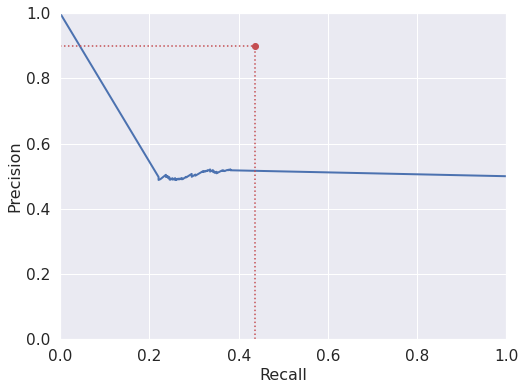

In [77]:

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

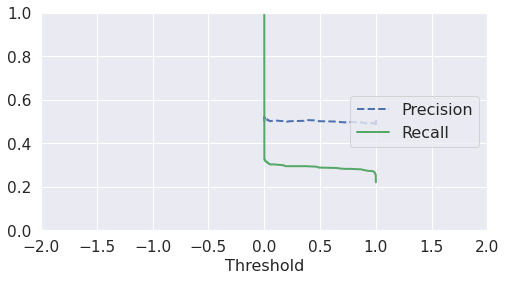

In [76]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-2, 2, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, Y_pred)


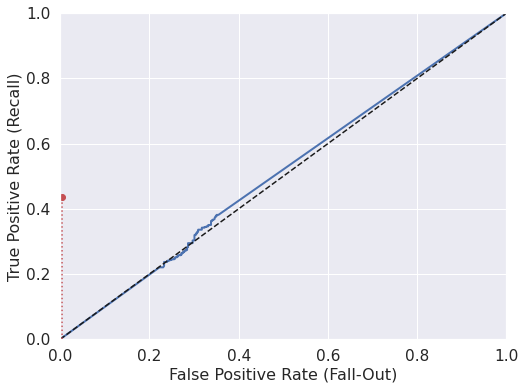

In [78]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
# save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(validation_generator.classes,Y_pred)

0.5092060792857901

In [34]:
print(classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       485
           1       0.50      0.29      0.36       485

    accuracy                           0.50       970
   macro avg       0.50      0.50      0.48       970
weighted avg       0.50      0.50      0.48       970



In [0]:
cm = confusion_matrix(validation_generator.classes, y_pred)

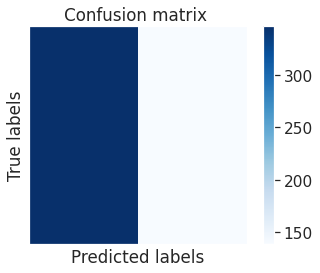

In [37]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [0]:
labels = train_generator.class_indices

In [0]:
import seaborn as sn
import pandas as pd

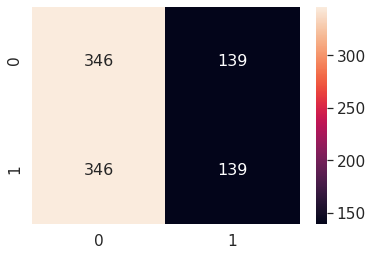

In [40]:
df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt="d") # font size

plt.show()